# Example Notebook Running scPortrait on datasets with multiple images

The scPortrait base Project class is focused on processing whole slide images. In case you want to process Image Datasets with multiple-images then you will need to use the scPortrait TimecourseProject class and associated methods. This tutorial will walk you through this process.

In [1]:
import os
import sys

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from scportrait.pipeline.extraction import TimecourseHDF5CellExtraction
from scportrait.pipeline.project import TimecourseProject
from scportrait.pipeline.workflows import Multithreaded_Cytosol_Cellpose_TimecourseSegmentation

## Some Helper Functions for visualization of results

In [2]:
from scportrait.processing.preprocessing import percentile_normalization


def plot_seg_overlay_timecourse(project_path, channel_to_show=0, seg_mask_to_show=0, selection=None, return_fig=False):
    seg_path = f"{project_path}/segmentation/input_segmentation.h5"
    with h5py.File(seg_path, "r") as hf:
        segmentation = hf.get("segmentation")
        channels = hf.get("input_images")

        print(segmentation)
        print(channels)

        if selection is None:
            segmentation = segmentation[0, seg_mask_to_show, :, :]
            image = channels[0, channel_to_show, :, :]

            fig = plt.figure()
            plt.imshow(percentile_normalization(image), cmap="Greys_r")
            plt.imshow(segmentation, alpha=0.5, cmap="jet")
            plt.axis("off")

        if return_fig:
            return fig


def visualize_single_cells(project_path, n_cells=10):
    cells_path = f"{project_path}/extraction/data/single_cells.h5"

    with h5py.File(cells_path, "r") as hf:
        cells = hf.get("single_cell_data")
        n_channels = cells.shape[1]

        fig, axs = plt.subplots(n_cells, n_channels, figsize=(n_channels * 1, n_cells * 1))

        for i in range(n_cells):
            image = cells[i]
            for n in range(n_channels):
                axs[i, n].imshow(image[n])
                axs[i, n].axis("off")

## Initialize a Project

scPortrait works with a project structure that is kept the same across different projects. Each project contains all of the results from one run. Each Project has the same general structure:

    .
    ├── featurization
    │   └── featurizer_name
    │       └── processing.log
    ├── config.yml
    ├── extraction
    ├── segmentation
    └── processing.log


At the beginning of a scPortrait analysis a new project is generated where configuration parameters are loaded from the config file. This determines how each processing step will be executed.Here is a minimal example including the different cellpose segmentation methods for TimecourseProjects.

    ---
    name: "Example Timecourse Project"
    input_channels: 3
    output_channels: 5
    Cytosol_Cellpose_TimecourseSegmentation:
        input_channels: 3
        output_masks: 2
        shard_size: 4000000 # Average number of pixel per tile. 10.000 * 10.000 pixel are recommended. Can be adapted to memory and computation needs. 
        chunk_size: 50 # chunk size for chunked HDF5 storage. is needed for correct caching and high performance reading. should be left at 50.
        cache: "."
        lower_quantile_normalization:   0.001
        upper_quantile_normalization:   0.999
        median_filter_size:   4 # Size in pixels
        nucleus_segmentation:
            model: "nuclei"
        cytosol_segmentation:
            model: "cyto2"
        chunk_size: 50
        match_masks: True
        filtering_threshold_mask_matching: 0.95
        filter_masks_size: False
    Multithreaded_Cytosol_Cellpose_TimecourseSegmentation:
        input_channels: 3
        output_masks: 2
        shard_size: 4000000 # Average number of pixel per tile. 10.000 * 10.000 pixel are recommended. Can be adapted to memory and computation needs. 
        chunk_size: 50 # chunk size for chunked HDF5 storage. is needed for correct caching and high performance reading. should be left at 50.
        threads: 5 # number of shards / tiles segmented at the same size. should be adapted to the maximum amount allowed by memory.
        cache: "."
        lower_quantile_normalization:   0.001
        upper_quantile_normalization:   0.999
        median_filter_size:   4 # Size in pixels
        nucleus_segmentation:
            model: "nuclei"
        cytosol_segmentation:
            model: "cyto2"
        chunk_size: 50
        match_masks: True
        filtering_threshold_mask_matching: 0.95
        filter_masks_size: False
    TimecourseHDF5CellExtraction:
        compression: True
        threads: 80 # threads used in multithreading
        image_size: 128 # image size in pixel
        cache: "."
        hdf5_rdcc_nbytes: 5242880000 # 5gb 1024 * 1024 * 5000 
        hdf5_rdcc_w0: 1
        hdf5_rdcc_nslots: 50000

In [3]:
# initialize project
project_location = "../../../example_data/example_5/project"

project = TimecourseProject(
    project_location,
    config_path="../../../example_data/example_5/config_example5.yml",
    segmentation_f=Multithreaded_Cytosol_Cellpose_TimecourseSegmentation,
    extraction_f=TimecourseHDF5CellExtraction,
    overwrite=False,
    debug=False,
)

modifying config


/Users/sophia/Documents/GitHub/SPARCSspatial/src/scportrait/pipeline/project.py:154: UserWarning: There is already a directory in the location path
  warnings.warn("There is already a directory in the location path")


## Input Data Format

scPortrait was optimized to work with Data generated using an Opera Phenix Microscope. Each Project class has several data_loader functions associated with it that can be used to load data from different sources. You can find the code under `src/scportrait/project.py`. The Dataloaders that load images from files are optimzied for file_name notation generated by the Phenix and the associated processing scripts. 

Data Format for `load_input_from_files`:

    .... main directory
        - Row02_Well02_Row02_Well02
            - Timepoint001_Row02_Well02_Alexa488_zstack001Row02_Well02.tif
            - Timepoint001_Row02_Well02_mCherry_zstack001_r000_c000.tif
            - Timepoint001_Row02_Well02_DAPI_zstack001_r000_c000.tif
        - ...

Alternatively you can load data from a numpy array using `load_input_from_array` which can be used more flexibly to write your own dataloader:

- images needs to be supplied in the shape (N, C, X, Y) to the parameter img
- labels need to be supplied as a tidy dataframe to the parameter label. The first two columns of the dataframe need to contian the following information: row_index, unique Image ID. Then you can append as many additional labels as you want. 

Also feel free to submit a PR with a new dataloader for a common microscopy file format.

## Example Load data using the from files function

In [4]:
# %%timeit -n 1
channels = ["DAPI", "Alexa488", "mCherry"]
timepoints = ["Timepoint" + str(x).zfill(3) for x in list(range(1, 3))]
input_dir = "../../../example_data/example_5/input_images"
plate_layout = "../../../example_data/example_5/plate_layout.tsv"

project.load_input_from_files(
    input_dir=input_dir, channels=channels, timepoints=timepoints, plate_layout=plate_layout, overwrite=True
)

  0%|          | 0/2 [00:00<?, ?it/s]

Images and labels are written to the `input_segmentation.h5` HDF5 file contained under segmentation in the project folder.
The input images are written to the container "input_images" and the labels to "labels". Column names are saved in a seperate dataset with the name "label_names".


In [5]:
with h5py.File(f"{project_location}/segmentation/input_segmentation.h5") as hf:
    print(hf.get("input_images"))
    print(hf.get("labels"))

    print("Example Label Dataset")
    print(hf.get("label_names")[:])
    print(hf.get("labels")[:])

<HDF5 dataset "input_images": shape (4, 3, 1080, 1080), type "<u2">
<HDF5 dataset "labels": shape (4, 8), type "|O">
Example Label Dataset
[b'index' b'ID' b'location' b'timepoint' b'well' b'region' b'Genotype'
 b'Treatment']
[[b'0' b'Row02_Well04_r004_c004_Timepoint001' b'Row02_Well04_r004_c004'
  b'Timepoint001' b'Row02_Well04' b'r004_c004' b'Genotype2' b'Stimulated']
 [b'1' b'Row02_Well04_r004_c004_Timepoint002' b'Row02_Well04_r004_c004'
  b'Timepoint002' b'Row02_Well04' b'r004_c004' b'Genotype2' b'Stimulated']
 [b'2' b'Row02_Well02_r000_c000_Timepoint001' b'Row02_Well02_r000_c000'
  b'Timepoint001' b'Row02_Well02' b'r000_c000' b'Genotype1'
  b'Unstimulated']
 [b'3' b'Row02_Well02_r000_c000_Timepoint002' b'Row02_Well02_r000_c000'
  b'Timepoint002' b'Row02_Well02' b'r000_c000' b'Genotype1'
  b'Unstimulated']]


## Segmentation

scPortrait has different segmentation workflows between which you can choose. If you run a timecourse project you will need to also select a timecourse segementation method. 

**notes on cellpose segmentation methods:**

Cellpose currently does not allow for the processing of image batches. Each image will thus be segmented individually on the GPU. In case you have large images this isnt an issue since the GPU is still fully utilzed (the sharding parameter can be used to set an optimal shard size for maximizing GPU utilization). For a large quantity of small images this leads to a very inefficient processing. To improve the speed a bit you can try running with multiple threads. Each thread will also load the model though so it requires quite some Memory overhead. This is hopefully an issue we can address in future releases. If its something you would like to work on get in touch with the developers we are happy for help!

In [6]:
project.segment()

Generating Shards:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

All segmentations are done.


Adjusting Indexes:   0%|          | 0/4 [00:00<?, ?it/s]

Segmentation results are written to the `input_segmentation.h5` HDF5 file in a new data container called "segmentation". 
In addition a csv file called classes.csv is generated which contains all the cell_ids that are not located in image edges and will be further processed.

If we look at the segmentation dataset we can see that it contains a numpy array containing two segmentation masks for each input image: the nuclear segmentation and the cytosol segmentation generated by our chosen segmentation method. If you use the method CytosolOnly both of the masks will be identical.

<HDF5 dataset "segmentation": shape (4, 2, 1080, 1080), type "<u4">
<HDF5 dataset "input_images": shape (4, 3, 1080, 1080), type "<u2">
<HDF5 dataset "segmentation": shape (4, 2, 1080, 1080), type "<u4">
<HDF5 dataset "input_images": shape (4, 3, 1080, 1080), type "<u2">
<HDF5 dataset "segmentation": shape (4, 2, 1080, 1080), type "<u4">
<HDF5 dataset "input_images": shape (4, 3, 1080, 1080), type "<u2">
<HDF5 dataset "segmentation": shape (4, 2, 1080, 1080), type "<u4">
<HDF5 dataset "input_images": shape (4, 3, 1080, 1080), type "<u2">


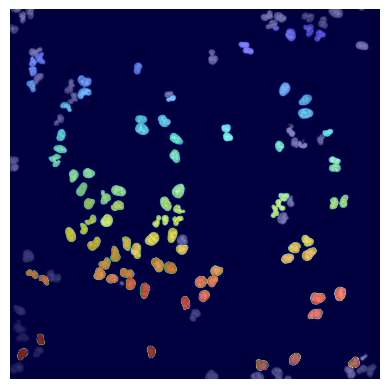

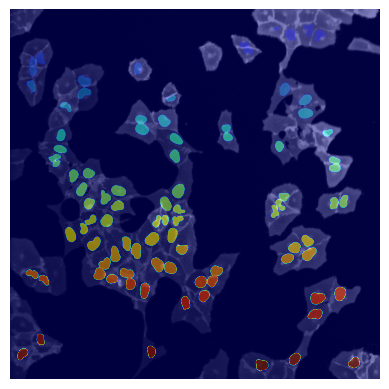

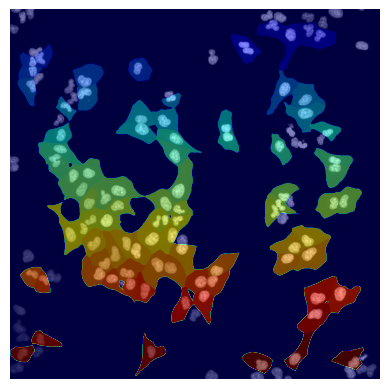

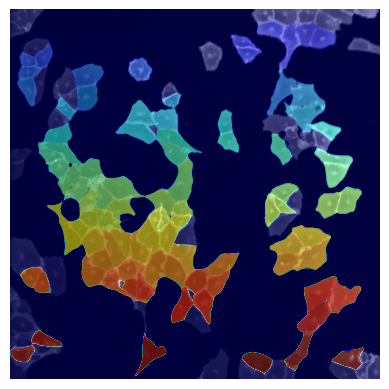

In [7]:
plot_seg_overlay_timecourse(project_location, channel_to_show=0)
plot_seg_overlay_timecourse(project_location, channel_to_show=1)

plot_seg_overlay_timecourse(project_location, channel_to_show=0, seg_mask_to_show=1)
plot_seg_overlay_timecourse(project_location, channel_to_show=1, seg_mask_to_show=1)

## Single-Cell Extraction

In [8]:
project.extract()

  0%|          | 0/4 [00:00<?, ?it/s]

The extracted single-cell images are written to a h5py file single_cells.h5 located under `extraction\data` within the project folder.

The file contains four datasets: `single_cell_data`, `single_cell_index`, `single_cell_index_labelled`, `label_names`. 

`single_cell_data` contains the extracted single cell images while `single_cell_index` contains the cell id of the extracted cell at that location.

The other two datacontainers integrated the labels from the base dataset and attach them to each cell.

In [9]:
with h5py.File(f"{project_location}/extraction/data/single_cells.h5") as hf:
    print(hf.keys())

    print(hf.get("label_names")[:])
    print(hf.get("single_cell_index_labelled")[2])

<KeysViewHDF5 ['label_names', 'single_cell_data', 'single_cell_index', 'single_cell_index_labelled']>
[b'index' b'cellid' b'ID' b'location' b'timepoint' b'well' b'region'
 b'Genotype' b'Treatment']
[b'17' b'Row02_Well04_r004_c004_Timepoint001' b'Row02_Well04_r004_c004'
 b'Timepoint001' b'Row02_Well04' b'r004_c004' b'Genotype2' b'Stimulated']


In [10]:
# single cell index contains two columns, the first is the index position in the hdf5 datacontainer, the second is the cell id

with h5py.File(f"{project_location}/extraction/data/single_cells.h5") as hf:
    # print(hf["single_cell_index"][0:10])
    print(hf["single_cell_index"][2])

[ 2 17]


In [11]:
# single cell index labelled contains the same information as single_cell_index
# in the first two columns but adds additional columns with labelling information, the column names for
# the labelling information is contained in label_names

with h5py.File(f"{project_location}/extraction/data/single_cells.h5") as hf:
    print(hf["label_names"][:])
    print(hf["single_cell_index_labelled"][2])

[b'index' b'cellid' b'ID' b'location' b'timepoint' b'well' b'region'
 b'Genotype' b'Treatment']
[b'17' b'Row02_Well04_r004_c004_Timepoint001' b'Row02_Well04_r004_c004'
 b'Timepoint001' b'Row02_Well04' b'r004_c004' b'Genotype2' b'Stimulated']


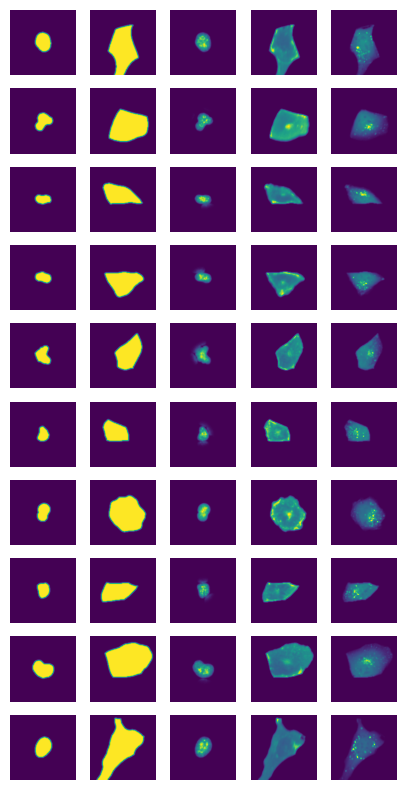

In [12]:
visualize_single_cells(project_location)